<h2><b>Main task analysis - excluding outliers</b></h2>
<p>Takes the summary table from the task analysis and tests H1a - <b>regressive errors are reduced and perseverative errors are increased in disgust learning</b></p>
<p>Exactly the same as the analyses done before but excluding outliers this time </p>
<p> Includes:</p>
<li>Hypothesis testing
<li>Model assumption tests 
<li>Adding covariates and random effects --> random intercepts for fractals and videos used in the task (feedback_randint) and by-participant random slopes; age, sex and working memory covariates
<li>Adding video rating scores
<li>Bayesian t-tests to assess strength of any null findings
<li>Follow-up, win-stay/lose-shift analyses
<br>
<p>NB this current version is run on fake data - randomly generated so won't see any expected effects

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
from scipy.stats import ttest_rel
#from statannotations.Annotator import Annotator
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PowerTransformer
import statannot
from scipy.stats import ttest_ind
import itertools

from dataclean_func import *
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [2]:
##remove later --> just getting rid of convergence warnings for dummy data
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
task_summary=pd.read_csv('csvs/dummy_dem_vids_task.csv')

<h3><b>Main hypothesis test</b></h3>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 1) 'mean_perseverative_er ~ block_type'
<li> 2) 'mean_regressive_er ~ block_type'

<b> MODEL 1: PERSEVERATIVE ERRORS </b>

Firstly - check the outcome for skewness

Perseverative error skew: -0.342306841617831


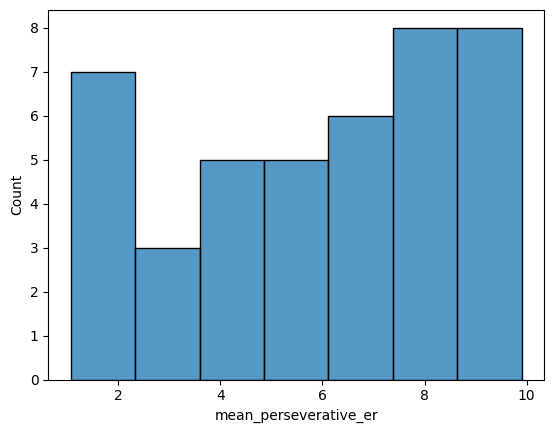

In [4]:
sns.histplot(data=task_summary, x="mean_perseverative_er") 
print('Perseverative error skew: '+str(skew(task_summary.mean_perseverative_er)))
#if skew isn't greater than 0.5 or less than -0.5 then nothing needs to be done
    #for an example of a skewed outcome (and what we would do) see regressive errors section

<b>Now run the initial hypothesis testing models</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

<b>H1a</b> Effect of feedback-type on perseverative error

In [5]:
data=task_summary.reset_index()

formula = 'mean_perseverative_er ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_andint  fractals_randint feedback_fractals_randint  \
0   215.480784        219.13869         219.13869              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  233.16702                   236.90469                        NOT CONVERGE  


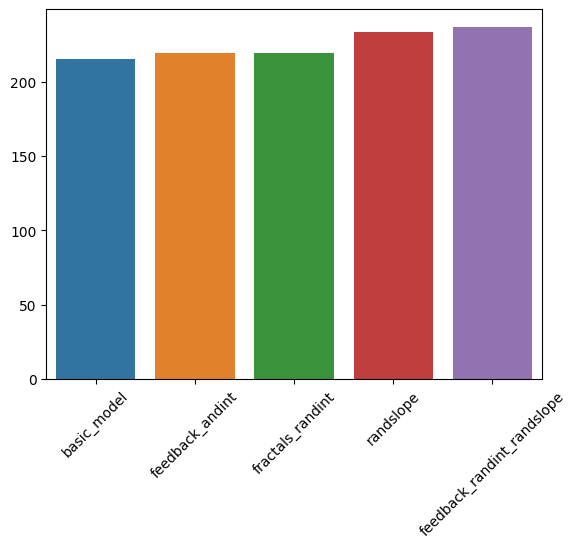

In [6]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0    215.480784     218.199787     217.087091            218.178636   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0         220.615761                220.545703                218.725129   

   sex_age_digit_span_covariate  
0                    222.183217  


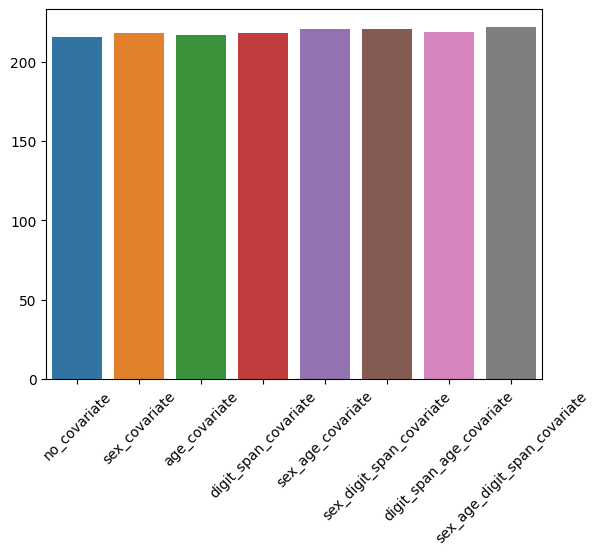

In [7]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, nocovariate is the best

In [8]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             ML                   
No. Groups:       14      Scale:              4.7698               
Min. group size:  3       Log-Likelihood:     -98.3962             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 5.923    0.703  8.424 0.000  4.545  7.302
block_type[T.Fear]        0.240    0.825  0.291 0.771 -1.378  1.858
block_type[T.Points]     -0.049    0.825 -0.059 0.953 -1.667  1.569
Group Var                 2.153    0.793                           
===================================================================

"""

<h4>Test the assumptions of the final model</h4> 
<p>The model we are basing our conclusions on
<p>NB in this dummy data, we are ignoring the instances that assumptions are violated, on the assumption that this is due to properties of our 'dummy' data which has quite a small sample

In [9]:
#checking assumptions 
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9266265919483259
p-value 0.009985520700804483
LM Statistic 0.600646392668402
LM-Test p-value 0.7405788296357223
F-Statistic 0.2829175732579465
F-Test p-value 0.7551152872789422


<h4>Computing Bayes factor to see strength of the null</h4>
<li>This part is very much dependent on the outcome of the hypothesis test
<li>e.g., if there is no difference between fear and disgust in the hypothesis test --> will follow this up with a Bayesian t-test to see the strength of the null for this key comparison
<br>
<br>
<p>Will interpret this bayes factor using Figure 4 from:
<p>Van Doorn, Johnny & van den Bergh, Don & Boehm, Udo & Dablander, Fabian & Derks, Koen & Draws, Tim & Evans, Nathan & Gronau, Quentin & Hinne, Max & Kucharský, Šimon & Ly, Alexander & Marsman, Maarten & Matzke, Dora & Raj, Akash & Sarafoglou, Alexandra & Stefan, Angelika & Voelkel, Jan & Wagenmakers, Eric-Jan. (2019). The JASP Guidelines for Conducting and Reporting a Bayesian Analysis. Psychonomic Bulletin and Review. 10.3758/s13423-020-01798-5

In [10]:
##create a function to do this using the pinguouin package
        #NB for simplicity just doing pair-wise t-tests for key conditions
def bayes_factor(df, dependent_var, condition_1_name, condition_2_name):
    to_exclude=list(df[pd.isna(df[dependent_var])].participant_no)
    for participant in to_exclude:
        df=df[df['participant_no'] != participant]
    condition1=task_summary[task_summary.block_type==condition_1_name][dependent_var]
    condition2=task_summary[task_summary.block_type==condition_2_name][dependent_var]

    ttest=pg.ttest(condition1, condition2, paired=True)
    bf_null=1/float(ttest.BF10) ##convert this into a bayes factor for the strength of the null
    return bf_null

In [11]:
bayes_factor(task_summary, 'mean_perseverative_er', 'Fear', 'Disgust')

3.571428571428571

<b> MODEL 2: REGRESSIVE ERRORS </b>
<p> Same again but with regressive rather than perseverative errors</p>
<p> This time I have made the outcome variable skewed so show how this would be dealt with </p>

Firstly - check the outcome for skewness

Regressive error skew: 2.282893324119201


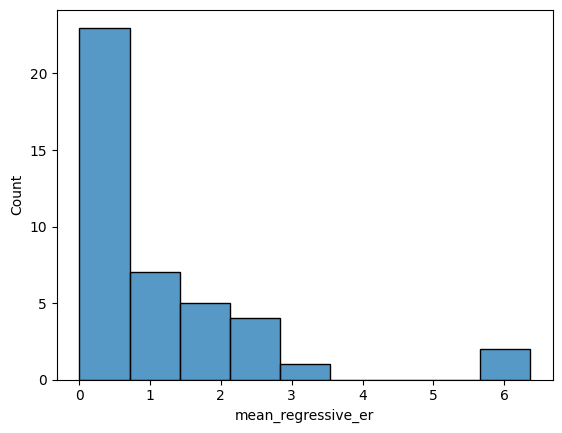

In [12]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution - so skew value >0.5
sns.histplot(data=task_summary, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary.mean_regressive_er,  nan_policy='omit')))

Given that the distribution was skewed, must perform a transformation

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

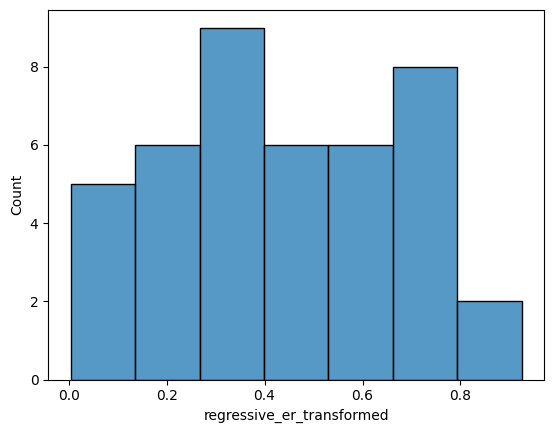

In [13]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
task_summary['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
sns.histplot(data=task_summary['regressive_er_transformed'])

<b>Now run the hypothesis testing model on the transformed variable</b>
<p><p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing (as with above):

In [14]:
data=task_summary.reset_index()

formula = 'regressive_er_transformed ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_andint  fractals_randint feedback_fractals_randint  \
0    17.624688        17.624688         17.624688              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  31.150046                   34.887715                        NOT CONVERGE  


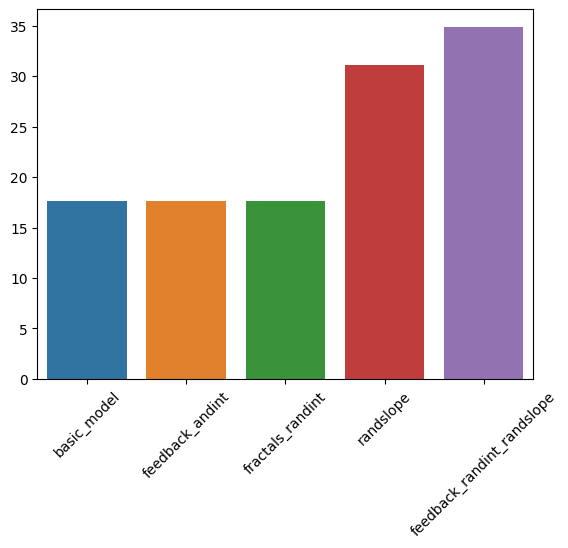

In [15]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)
        #also had to comment out because it does not converge and errors out

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})##added manually
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     17.624688       21.14766      21.359697              21.18426   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          24.806131                   24.7433                 24.903698   

   sex_age_digit_span_covariate  
0                     28.359679  


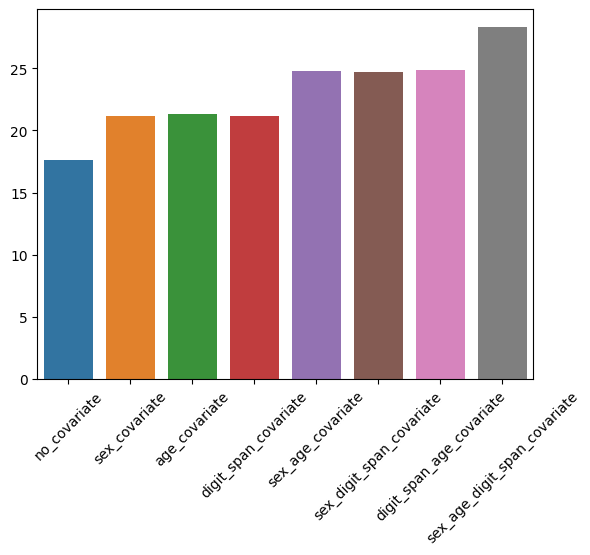

In [16]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, nocovariate is the best

In [17]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 42      Method:             ML                       
No. Groups:       14      Scale:              0.0571                   
Min. group size:  3       Log-Likelihood:     0.5318                   
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.492     0.064   7.705  0.000   0.367   0.617
block_type[T.Fear]       -0.109     0.090  -1.212  0.226  -0.286   0.068
block_type[T.Points]     -0.054     0.090  -0.603  0.547  -0.231   0.123
Group Var                 0.000     0.038                               
=======================================================================

"""

Test the assumptions of this final model

In [18]:
#again checking assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9844592832136687
p-value 0.8286903157627699
LM Statistic 3.9814924794437494
LM-Test p-value 0.13659345594083727
F-Statistic 2.0421396949150186
F-Test p-value 0.14339783140885745


Compute the Bayes factors for any null finding

In [19]:
bayes_factor(task_summary, 'regressive_er_transformed', 'Fear', 'Points')

3.3333333333333335

<h3><b>Adding video ratings</b></h3>
<p>Testing whether this result is modified by adding video ratings: </p>
<p>=models 3 and 4 in the analysis plan
<p><b>ONLY TO BE RUN IF RESULTS OF VIDEO RATINGS WARRANT IT</b>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

<b> MODEL 3: PERSEVERATIVE ERRORS W VIDEO RATINGS </b>

In [20]:
#e.g., if there was a difference in valence habituation and baseline arousal
# identified by a difference in valence habituation (valence_habdiff)
        #i.e., a time*stimulus type interaction in valence model (model A)
# and an effect of stimulus type in arousal model (model B)
#so add valence_habdiff and arousal_diff to the model as covariates

data=task_summary.reset_index()

formula = 'mean_perseverative_er ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_andint  fractals_randint  feedback_fractals_randint  \
0   218.510917       219.932491        219.932491                 223.670161   

    randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  236.695664                  240.433334                        NOT CONVERGE  


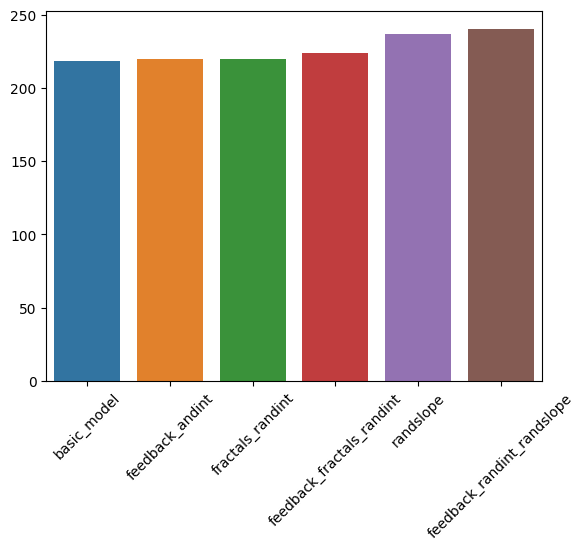

In [21]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)
        #had to comment out because it does not converge and errors out

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0    218.510917     217.121354     218.605951            221.306538   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0         219.345336                219.503211                220.110334   

   sex_age_digit_span_covariate  
0                    220.839112  


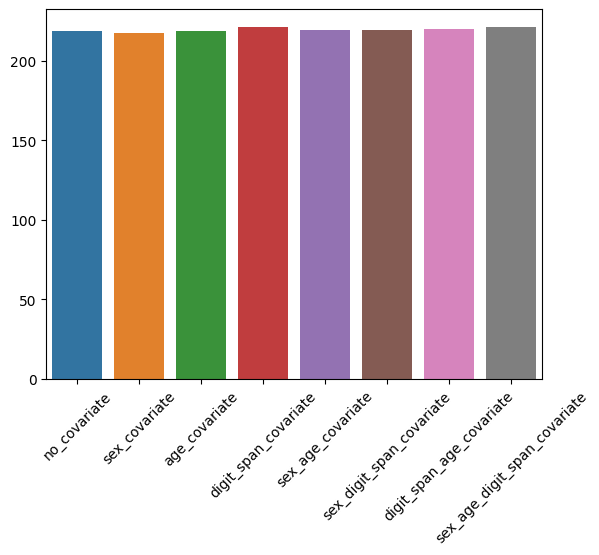

In [22]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, just the sex covariate is best

In [23]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
sex_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             ML                   
No. Groups:       14      Scale:              4.7698               
Min. group size:  3       Log-Likelihood:     -93.6100             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 4.679    0.768  6.094 0.000  3.174  6.184
block_type[T.Fear]        0.240    0.825  0.291 0.771 -1.378  1.858
block_type[T.Points]     -0.049    0.825 -0.059 0.953 -1.667  1.569
prolific_sex[T.Male]      2.013    0.809  2.488 0.013  0.427  3.598
arousal_diff              0.218    0.093  2.355 0.019  0.037  0.400
valence_habdiff          -0.157    0.071 -2.201 0.028 -0.296 -0.017
Group Var                 0.299    0.400                           
===================================================================

"""

In [24]:
#no covariate model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             ML                   
No. Groups:       14      Scale:              4.7698               
Min. group size:  3       Log-Likelihood:     -96.1736             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 5.864    0.651  9.013 0.000  4.589  7.139
block_type[T.Fear]        0.240    0.825  0.291 0.771 -1.378  1.858
block_type[T.Points]     -0.049    0.825 -0.059 0.953 -1.667  1.569
arousal_diff              0.194    0.111  1.749 0.080 -0.023  0.411
valence_habdiff          -0.092    0.080 -1.153 0.249 -0.248  0.064
Group Var                 1.134    0.577                           
===================================================================

"""

In [25]:
#again checking assumptions

#chose model
results=sex_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9758149719450674
p-value 0.5061979556312728
LM Statistic 16.036882572237012
LM-Test p-value 0.45038963486754313
F-Statistic 0.9651240490991887
F-Test p-value 0.5175349861914583


<b> MODEL 4: REGRESSIVE ERRORS W VIDEO RATINGS </b>

Do the same for regressive errors

In [26]:
#e.g., same scenario as above
#note still using transformed outcome variable (as it is skewed)

formula = 'regressive_er_transformed ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_andint  fractals_randint feedback_fractals_randint  \
0    21.568855        21.568585         21.568585              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  34.835454                   38.573124                        NOT CONVERGE  


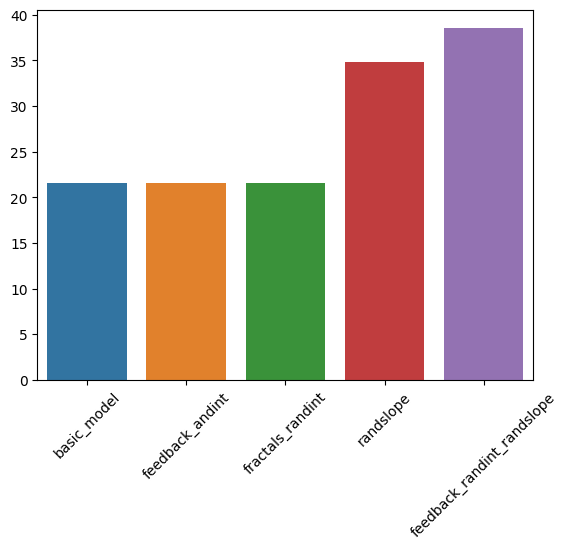

In [27]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best
        #if two models have the same BIC we got for the simplest model (models are in order of simplicity)

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     21.568855      24.688105      25.298432             25.218632   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          28.198581                 28.334752                 28.936705   

   sex_age_digit_span_covariate  
0                     31.779468  


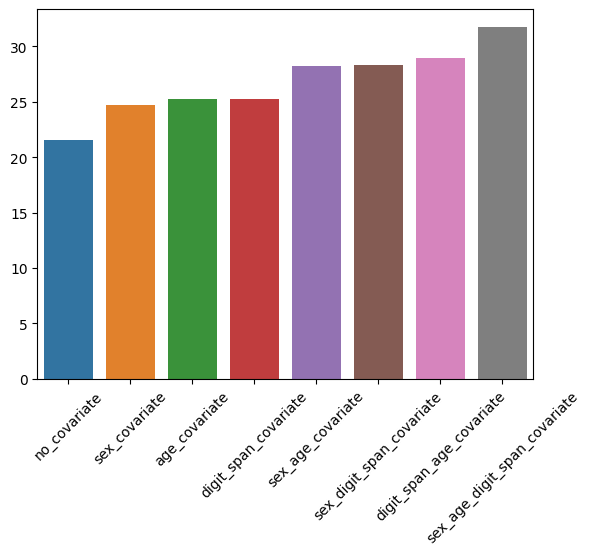

In [28]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, no covariate is best
    

In [29]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 42      Method:             ML                       
No. Groups:       14      Scale:              0.0525                   
Min. group size:  3       Log-Likelihood:     2.2974                   
Max. group size:  3       Converged:          No                       
Mean group size:  3.0                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.493     0.061   8.034  0.000   0.372   0.613
block_type[T.Fear]       -0.109     0.087  -1.264  0.206  -0.279   0.060
block_type[T.Points]     -0.054     0.087  -0.628  0.530  -0.224   0.115
arousal_diff             -0.017     0.009  -1.915  0.055  -0.034   0.000
valence_habdiff          -0.001     0.006  -0.205  0.837  -0.014   0.011
Group Var                 0.000     0.046                               
=======================================================================

"""

In [30]:
#again checking assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9755553360949368
p-value 0.49720702094177
LM Statistic 10.476832358013963
LM-Test p-value 0.48807295891907654
F-Statistic 0.9064183994048551
F-Test p-value 0.5459157287819949


<h3><b>Win-stay/lose-shift analyses</b></h3>
<p>Only to be run if there are differences in regressive or perseverative errors across the block types (significant effects of block type in models 1 or 2)</p>
<p>Models to run: </p>
<li> 5) 'win_stay ~ block_type + any covariates that were significant in models 1 and 2'
<li> 6) 'lose_shift ~ block_type + any covariates that were significant in models 1 and 2'

<b> MODEL 5: WIN-STAY </b>

Win-stay  skew: 0.27120031892898655


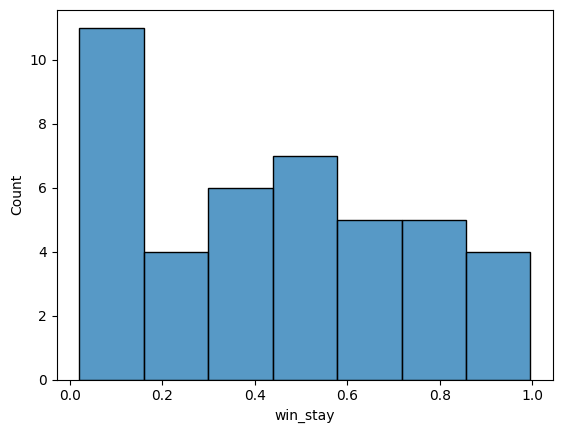

In [31]:
sns.histplot(data=task_summary, x="win_stay") 
print('Win-stay  skew: '+str(skew(task_summary.win_stay)))

In [32]:
##most basic model
formula = 'win_stay ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint feedback_fractals_randint  \
0    30.993585         30.993551         30.993551              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0   47.48811                   50.653484                        NOT CONVERGE  


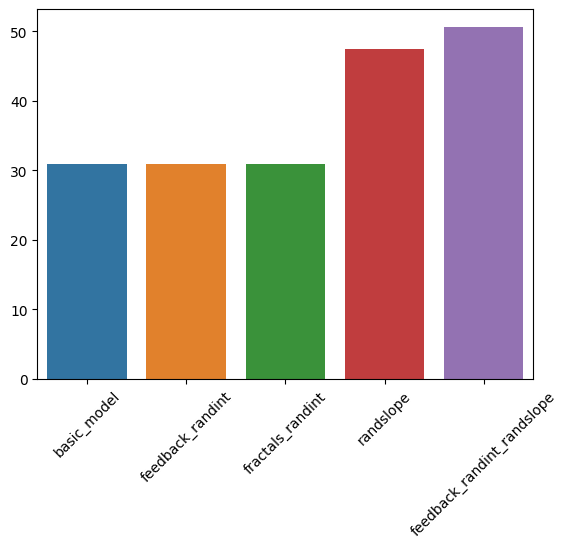

In [33]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, is is with feedback rand intercept (which fear/disgust vids used)

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     30.993551      34.275066      34.731093             34.229511   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          37.897363                 37.392683                 37.951079   

   sex_age_digit_span_covariate  
0                     41.083753  


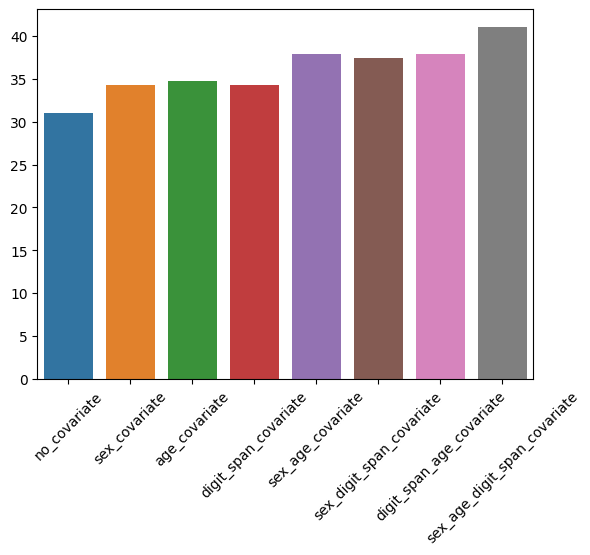

In [34]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, no covariate is best

In [35]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    win_stay
No. Observations:    42         Method:                ML      
No. Groups:          14         Scale:                 0.0392  
Min. group size:     3          Log-Likelihood:        -6.1526 
Max. group size:     3          Converged:             Yes     
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.417    0.047  8.878 0.000  0.325  0.509
block_type[T.Fear]   -0.046    0.023 -2.018 0.044 -0.091 -0.001
block_type[T.Points]  0.095    0.078  1.218 0.223 -0.058  0.248
feedback_details Var  0.039                                    
===============================================================

"""

Test the assumptions of this model

In [36]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9608901406137517
p-value 0.15891794053974684
LM Statistic 1.1387209768950382
LM-Test p-value 0.5658872144183534
F-Statistic 0.5434254526613664
F-Test p-value 0.5850890782531676


Also calculate Bayes factor for strenght of null

In [37]:
bayes_factor(task_summary, 'win_stay', 'Fear', 'Disgust')

3.4722222222222223

<b> MODEL 6: LOSE-SHIFT </b>

lose-shift  skew: 0.27120031892898655


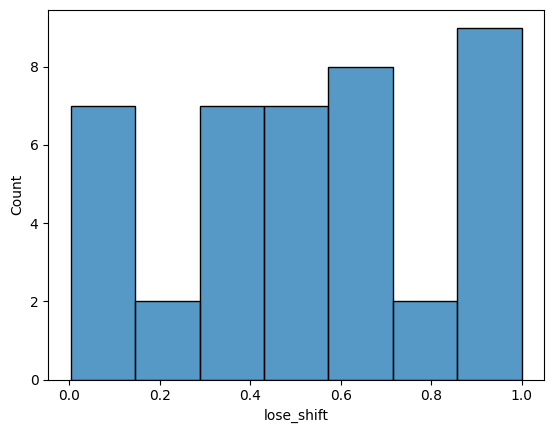

In [38]:
#check for skewness
sns.histplot(data=task_summary, x="lose_shift") 
print('lose-shift  skew: '+str(skew(task_summary.win_stay, nan_policy='omit')))

Now run the hypothesis testing model

In [39]:
formula = 'lose_shift ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint  feedback_fractals_randint  \
0    35.508298         35.507556         35.507556                 223.670161   

   randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  50.517042                   55.220971                            57.984781  


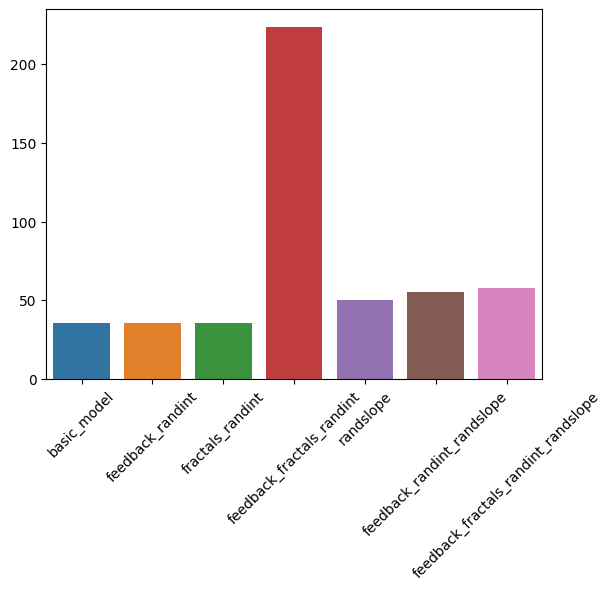

In [40]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, it is the most basic model

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     35.508298      39.203135      39.081439             38.121175   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          42.637116                 41.848911                 41.463317   

   sex_age_digit_span_covariate  
0                     45.035362  


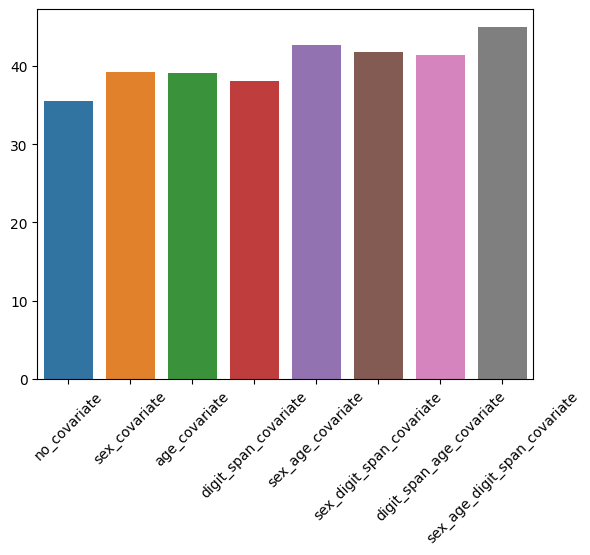

In [41]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, no covariate is best

In [42]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  lose_shift
No. Observations:    42       Method:              ML        
No. Groups:          14       Scale:               0.0874    
Min. group size:     3        Log-Likelihood:      -8.4100   
Max. group size:     3        Converged:           No        
Mean group size:     3.0                                     
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.515    0.079 6.523 0.000  0.361  0.670
block_type[T.Fear]   0.002    0.112 0.019 0.985 -0.217  0.221
block_type[T.Points] 0.033    0.112 0.296 0.767 -0.186  0.252
Group Var            0.000    0.062                          
=============================================================

"""

Test the assumptions of this model

In [43]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9520105399581213
p-value 0.07624910239440603
LM Statistic 1.4366848435848794
LM-Test p-value 0.48755975495341053
F-Statistic 0.6906574164827475
F-Test p-value 0.50727207084415


Calculate Bayes factor (if there is a null)

In [44]:
bayes_factor(task_summary, 'lose_shift', 'Fear', 'Points')

3.6101083032490973

<b>Finally (!) may also test the impact of adding video ratings to these analyses </b>
<p>This is very similar to models 3 and 4, i.e., is contingent on video rating analysis

In [45]:
data=task_summary.reset_index()

formula = 'win_stay ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint feedback_fractals_randint  \
0    33.858447         33.492226         33.492226              NOT CONVERGE   

   randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  44.343567                   48.081236                            51.818906  


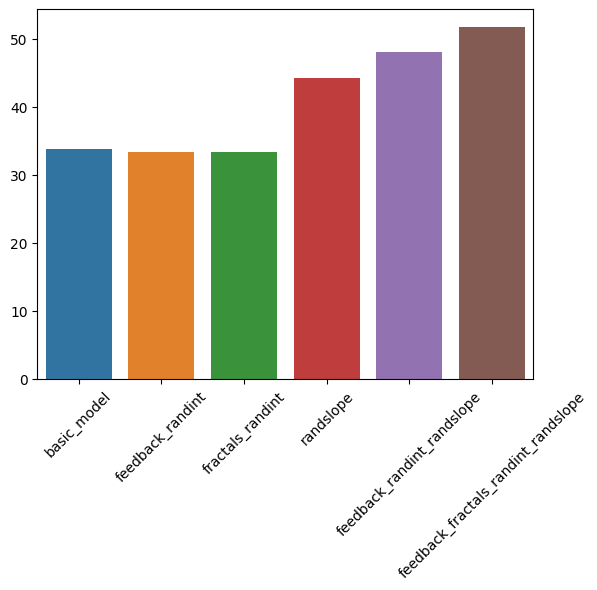

In [46]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, video-type (feedback_randint) is best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     33.492226      35.313002      37.228692             36.670233   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          38.655584                 38.472961                 40.382709   

   sex_age_digit_span_covariate  
0                      41.95846  


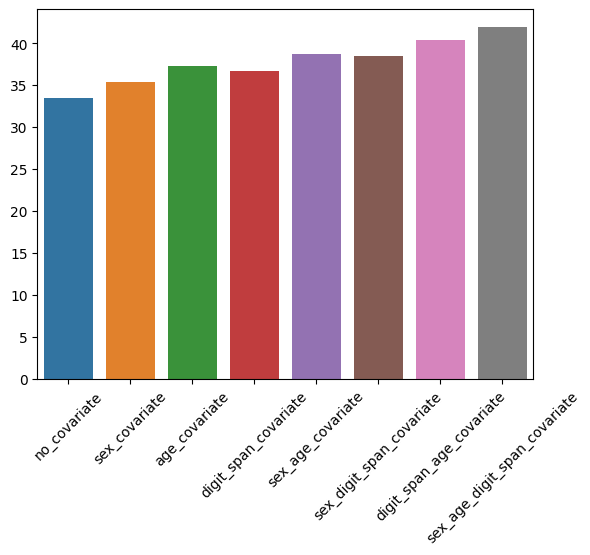

In [47]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, the most basic is best (no covariates)

In [48]:
#so hypothesis test on the no covariate model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    win_stay
No. Observations:    42         Method:                ML      
No. Groups:          14         Scale:                 0.0349  
Min. group size:     3          Log-Likelihood:        -3.6643 
Max. group size:     3          Converged:             Yes     
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.420    0.062  6.832 0.000  0.300  0.541
block_type[T.Fear]   -0.046    0.072 -0.647 0.518 -0.187  0.094
block_type[T.Points]  0.095    0.058  1.635 0.102 -0.019  0.209
arousal_diff         -0.022    0.010 -2.226 0.026 -0.041 -0.003
valence_habdiff       0.004    0.007  0.484 0.628 -0.011  0.018
feedback_details Var  0.035                                    
===============================================================

"""

In [49]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9642515788352749
p-value 0.20918956785664894
LM Statistic 11.476040925541568
LM-Test p-value 0.4042855884586521
F-Statistic 1.0253680840335255
F-Test p-value 0.44935991252256957


Same for lose-shift

In [50]:
formula = 'lose_shift ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint feedback_fractals_randint  \
0    41.620906         41.619668         41.619668              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  54.931967                   58.669637                        NOT CONVERGE  


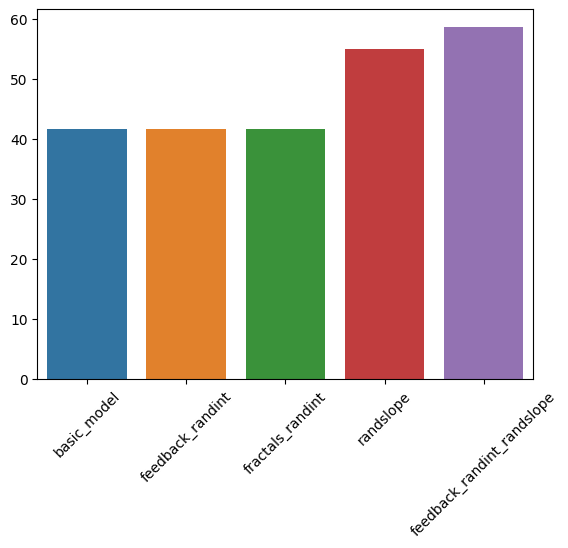

In [51]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, feedback rand int is best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     41.619668      45.283626      45.075396             44.642556   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          48.810717                 48.307022                 47.913516   

   sex_age_digit_span_covariate  
0                       51.6503  


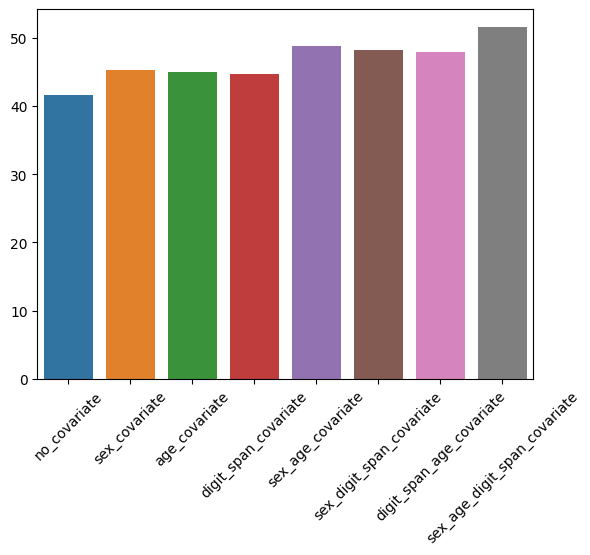

In [52]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, the most basic is best (no covariates)

In [53]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   lose_shift
No. Observations:    42        Method:               ML        
No. Groups:          14        Scale:                0.0423    
Min. group size:     3         Log-Likelihood:       -7.7280   
Max. group size:     3         Converged:            Yes       
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.520    0.026 20.117 0.000  0.469  0.570
block_type[T.Fear]    0.002    0.059  0.036 0.972 -0.114  0.118
block_type[T.Points]  0.033    0.079  0.420 0.674 -0.121  0.187
arousal_diff         -0.006    0.011 -0.508 0.611 -0.027  0.016
valence_habdiff       0.008    0.008  0.968 0.333 -0.008  0.024
feedback_details Var  0.042                                    
===============================================================

"""

In [54]:
#final check of model assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.969558371852567
p-value 0.3191525968415755
LM Statistic 25.104766971453234
LM-Test p-value 0.008800099003777501
F-Statistic 4.052477179219513
F-Test p-value 0.0011097425141380045
